# Homework Assignment 3 - Unsupervised Learning
### **Due:** Thursday, May 18, 11:59pm
### Total: 100 points

## Import all the libraries and tools you need below.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf
tf.config.run_functions_eagerly(True)

import os

os.getcwd()
os.chdir("C:\Data")
os.getcwd()

import pandas as pd
import numpy as np 
from numpy import log,dot,e,shape
from numpy import log,dot,e,shape
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from scipy.special import softmax

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import silhouette_score

from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import check_cv
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import make_blobs, make_circles

def pr_auc(y_true, probas_pred):
 # calculate precision-recall curve
 p, r, _ = precision_recall_curve(y_true, probas_pred)
 # calculate area under curve
 return auc(r, p)

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras import losses 
from keras import optimizers 
from keras import metrics

## **1)** Gaussian Mixture Model (35 points)

In this question, you will explore a Gaussian Mixture Model (GMM) for an unsupervised dataset.

**a)** Upload the **oldfaithful.csv** file. Each instance in this dataset is an eruption of the Old Faithful geyser in Yellowstone National Park. The **eruptions** column records how long the eruption took and the **waiting** column records how long it took until the next eruption, both in minutes.

Create a scatter plot and state how many clusters would make sense for this data. Note that you have the visualization advantage for this question; you will not have it in the upcoming questions. 

**(3 points)**

In [2]:
data = pd.read_csv('oldfaithful.csv')
data

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85
...,...,...
267,4.117,81
268,2.150,46
269,4.417,90
270,1.817,46


In [3]:
eruptions = data['eruptions']
waiting = data['waiting']

<AxesSubplot:ylabel='waiting'>

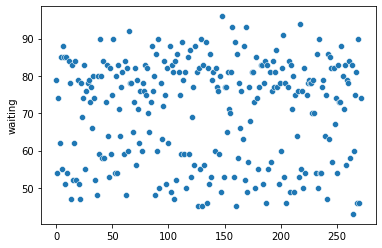

In [4]:
sns.scatterplot(data=data, x=data.index, y= 'waiting')

<AxesSubplot:ylabel='eruptions'>

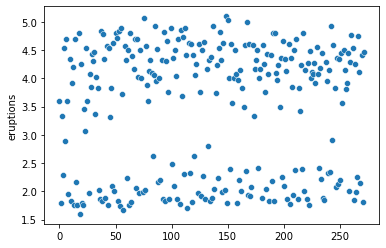

In [5]:
sns.scatterplot(data=data, x=data.index, y='eruptions')

1a. seems to have 2 clusters.

**b)** Cluster the data using K-Means and GMM models. Reproduce the plot above with color-coded clusters. Which model returns better results? Briefly explain why.

**Note:** Use a full covariance matrix for the GMM model.

**(5 points)**

In [6]:
cov_eruptions = np.cov(data.index, eruptions)
cov_waiting = np.cov(data.index, waiting)

features = data[['eruptions','waiting']].values

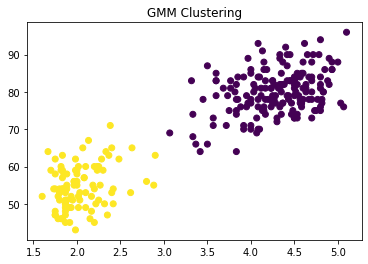

In [7]:
np.random.seed(0)
model_GMM = GaussianMixture(n_components=2, covariance_type = 'full', random_state=0) 
model_GMM.fit(features)
GMM_labels = model_GMM.predict(features)

plt.scatter(features[:, 0], features[:, 1], c=GMM_labels, cmap='viridis')
plt.title('GMM Clustering')
plt.show()

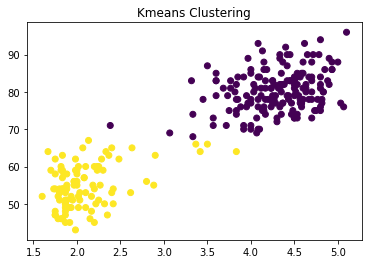

In [8]:
np.random.seed(0)
model = KMeans(n_clusters=2, max_iter=10000, n_init=100, random_state=0) 
#fits the model to the raw data and predicts the cluster given to the raw data
model.fit(features)
model_labels = model.labels_

plt.scatter(features[:, 0], features[:, 1], c=model_labels, cmap='viridis')
plt.title('Kmeans Clustering')
plt.show()

The model with better results seems to be the GMM model, becuase the Kmeans model has a few outliers that look to be within the "range" of GMM like the poiunt near 2.5:70. This is because In trying to create a more strict division between the clusters, the Kmeans model fails to see softer boundaries like the set of 4 points it misclassified between 3.4-4.0 and below 70.

**c)** Using the GMM model, return the probability for a 2-minute eruption and 54-minute waiting time for the next eruption.

**Note:** .predict_proba is not the answer to this question because it returns the normalized probabilities of the instance belonging to each cluster. What you need is the **multivariate_normal.pdf** function from **scipy**. You need **some attributes of the GMM model to use as input** to this function and **some more attributes** to take the **weighted** sum. Check the GMM slides for the full formula of the probability distribution.

**(7 points)**

In [9]:
#use cluster 1
mean_vector = model_GMM.means_[0]
covariance_matrix = model_GMM.covariances_[0]

values = [2.0, 54]
probability = multivariate_normal.pdf(values,
                                     mean_vector,
                                     covariance_matrix)
print("Probability for next eruption", probability)

Probability for next eruption 7.763535049527556e-10


**d)** Using your answer to the previous quesion, write a user-defined function called **anomaly_detector**. It takes two inputs: gmm, a trained model **with any number of clusters** and X, the data. It should return an array of 0s and 1s (or True and False values) with the same length as the dataset.

The function needs to calculate the probability of each instance in the dataset and return a 1 (True) for instances that has their probability in the bottom 5\% percentile of the dataset and 0 (False) otherwise.

Test your function with the data above and print how many anomalies there are.

**Hints:**

**1)** Note that you should not assume that the GMM has two clusters while writing the function. It should be able to handle a trained GMM model with any number of clusters.

**2)** For percentile calculations, check **np.percentile**.

**(10 points)**

In [10]:
np.random.seed(0)

model_gmm = GaussianMixture(n_components=2)
fitted_model_gmm = model_gmm.fit(data)
    
def anomaly_detector(model_gmm, X):
    
    log_likelihoods = model_gmm.score_samples(X)
    
    threshold = np.percentile(log_likelihoods, 5)

    anomalies = np.where(log_likelihoods < threshold, 1, 0)

    return anomalies


anomaly_detector(fitted_model_gmm, data)
print(len(anomaly_detector(fitted_model_gmm, data)))

272


**e)** **Sample** a synthetic dataset of 100 instances from the GMM model. Scatter plot the synthetic data. (No need to color code.) How is it different than the original dataset, in terms of the distribution of the instances? Why do you think this is the case?

**Note:** Careful with the format that the synthetic data GMM model returns.

**(5 points)**

In [11]:
np.random.seed(0)

synthetic = fitted_model_gmm.sample(n_samples=100)

samples = synthetic[0]
labels = synthetic[1]

synthetic

(array([[ 4.45564477, 84.53612349],
        [ 4.48661018, 82.63030606],
        [ 4.44623183, 88.9391485 ],
        [ 4.01352997, 81.85710163],
        [ 4.13790814, 64.63978842],
        [ 4.14275799, 85.16533943],
        [ 4.09208866, 93.60726138],
        [ 4.22564781, 80.24604477],
        [ 5.09030105, 89.15473781],
        [ 4.45819126, 80.89576906],
        [ 3.39568416, 74.66072357],
        [ 4.29471525, 77.87978064],
        [ 4.94108161, 87.34184106],
        [ 4.11377929, 77.64778283],
        [ 3.58409559, 73.69019723],
        [ 4.76508757, 69.70893058],
        [ 4.04284128, 76.91493055],
        [ 4.38927514, 72.44241467],
        [ 3.95529208, 70.28492217],
        [ 4.29657288, 74.59102134],
        [ 3.75974519, 76.9154123 ],
        [ 4.44854865, 79.79611156],
        [ 4.41546674, 80.36575908],
        [ 4.05196612, 76.1659018 ],
        [ 4.04719182, 75.93696087],
        [ 3.50437487, 75.10617801],
        [ 4.16456217, 81.03846249],
        [ 4.21010691, 70.180

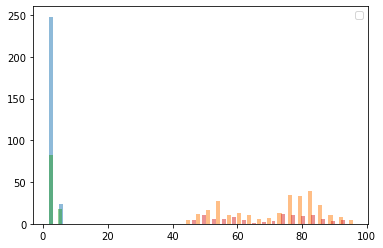

In [12]:
plt.hist(features, bins=30, alpha=0.5, label='Original')
plt.hist(samples, bins=30, alpha=0.5, label='Synthetic')
plt.xlabel('')
plt.ylabel('')
plt.legend('')
plt.show()

There are more pronounced modes, I think this is the case because we have lowered the n to just 100.

**f)** Is the GMM in this question a generative or a discriminative model? Briefly explain your reasoning. Also briefly explain why it would be beneficial to use for a data-based task that involves natural events like the Old Faithful geyser erupting.

**(5 points)**

It is a generative model, becuase it uses a combination of guassian distributions to model the joint distribution without explicitly considering the target variable of which we are trying to predict. 

Its beneficial to use GMM because it can capture irregular data structures, notably in its flexibility in capturing complex data and especially natural events with multi-modes like geyser eruptions. By also using probability to predict and using synthetically created data, which for natural enviornments is necessary since there is only 1 timeline, GMM incorporates many useful tools for its statistical approach.

## **2)** K-Means with Stock Market Data (25 points)

In this question, you will cluster companies using a K-Means model.

**a)** Upload the **stocks.csv** file. Each row is a company. The first column is the company name and the remaining columns are the daily price movements (the dollar difference between the closing and opening prices) for each trading day from early 2010 to late 2013.

Save the first column and the numeric columns into separate variables. You will need the numeric columns for clustering and the names at the end of this question.

**(3 points)**

In [13]:
data = pd.read_csv('stocks.csv')

data.head()

,Unnamed: 0,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,...,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
0,Apple,0.580000,-0.220005,-3.409998,-1.170000,1.680011,-2.689994,-1.469994,2.779997,-0.680003,...,0.320008,4.519997,2.899987,9.590019,-6.540016,5.959976,6.910011,-5.359962,0.840019,-19.589981
1,AIG,-0.640002,-0.650000,-0.210001,-0.420000,0.710001,-0.200001,-1.130001,0.069999,-0.119999,...,0.919998,0.709999,0.119999,-0.480000,0.010002,-0.279998,-0.190003,-0.040001,-0.400002,0.660000
2,Amazon,-2.350006,1.260009,-2.350006,-2.009995,2.960006,-2.309997,-1.640007,1.209999,-1.790001,...,2.109985,3.699982,9.570008,-3.450013,4.820008,-4.079986,2.579986,4.790009,-1.760009,3.740021
3,American express,0.109997,0.000000,0.260002,0.720002,0.190003,-0.270001,0.750000,0.300004,0.639999,...,0.680001,2.290001,0.409996,-0.069999,0.100006,0.069999,0.130005,1.849999,0.040001,0.540001
4,Boeing,0.459999,1.770000,1.549999,2.690003,0.059997,-1.080002,0.360000,0.549999,0.530002,...,1.559997,2.480003,0.019997,-1.220001,0.480003,3.020004,-0.029999,1.940002,1.130005,0.309998


In [14]:
y = data.iloc[:,0]
X = data.iloc[:, 1:]

**b)** Before any clustering, you need to keep in mind and account for the fact that different companies have different price levels. This will create problems while clustering their price movements because the price differences for more expensive companies will simply have more variance. 

Before taking care of this problem with some preprocessing, find out the companies with the highest and lowest price variance. (**Hint:** **.var** method of a DataFrame and **np.argmax/argmin.**)

**(5 points)**

In [15]:
print(np.argmax(data.var(axis=1)))
print(np.argmin(data.var(axis=1)))
print(y.iloc[17], y.iloc[34])

17
34
Google/Alphabet Mitsubishi


C:\Users\dylan\AppData\Local\Temp/ipykernel_7632/643082124.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(np.argmax(data.var(axis=1)))
C:\Users\dylan\AppData\Local\Temp/ipykernel_7632/643082124.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(np.argmin(data.var(axis=1)))


**c)** To take all instances (companies) to the same level of variance without losing the information they have on their features, you need to use a **Normalizer** object. Note that a Scaler object scales each column whereas a Normalizer object scales each row. (**Hint:** No need for any input to the object - just create it and **.fit_transform**.)

**(2 points)**

In [16]:
scaler_transform = Normalizer().fit(X)
scaler_transform.transform(X)
normalized_object = Normalizer().fit_transform(X)

**d)** Using the normalized data, run a **K-Means** model for each K value from 2 to 15. For each value, cluster the normalized data and store the **inertia** of the clustering model. At the end, plot the inertia values against the K values. Which K value has the elbow?

**Note:** Any elbow is difficult to see and there are multiple candidates. Pick the one with the output that makes the most sense to you. This kind of an inertia plot is what you would typically see in a real-life clustering task. While the inertia plots for toy datasets are good for learning the concept, they are really misleading in that sense.

**(8 points)**

Text(0, 0.5, 'Inertia')

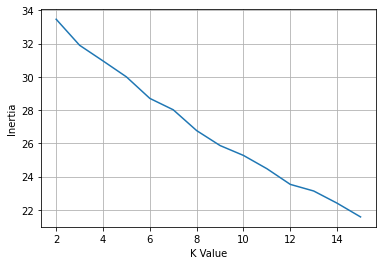

In [17]:
np.random.seed(0)

inertia_values = []
for k in range(2, 16):
    kmeans = KMeans(random_state = 0, n_clusters=k)
    kmeans.fit(normalized_object)
    inertia_values.append(kmeans.inertia_)
    
plt.plot([*range(2, 16)], inertia_values)
plt.grid()
plt.xlabel('K Value')
plt.ylabel('Inertia')



I think 12 is the elbow value because the overall inertia values of 24< can only get lower and porportionally with each K value, that means it is likely for the change to be less and less, even though it looks like 15's inertia value is getting steeper.

**e)** Create the final K-Means model with your pick for the best K value and return the cluster label predictions. Put the labels and the company names in a dataframe and sort it by the labels. Print the sorted dataframe.

**(4 points)**

In [18]:
x = data['Unnamed: 0']
x

0                                  Apple
1                                    AIG
2                                 Amazon
3                       American express
4                                 Boeing
5                        Bank of America
6               British American Tobacco
7                                  Canon
8                            Caterpillar
9                      Colgate-Palmolive
10                        ConocoPhillips
11                                 Cisco
12                               Chevron
13                     DuPont de Nemours
14                                  Dell
15                                  Ford
16                     General Electrics
17                       Google/Alphabet
18                         Goldman Sachs
19                       GlaxoSmithKline
20                            Home Depot
21                                 Honda
22                                    HP
23                                   IBM
24              

In [19]:
np.random.seed(0)

Kmeans = KMeans(random_state = 0, n_clusters = 6)
Kmeans.fit(normalized_object)
labels = kmeans.labels_

x = data['Unnamed: 0']

df_dumb = {'Company Name': x, 'Cluster Label': labels}
df = pd.DataFrame(df_dumb)
df_sorted = df.sort_values(by='Cluster Label', ascending= False)

df_sorted

,Company Name,Cluster Label
35,Navistar,14
24,Intel,14
51,Texas instruments,14
50,Taiwan Semiconductor Manufacturing,14
17,Google/Alphabet,13
0,Apple,13
2,Amazon,13
41,Philip Morris,12
38,Pepsi,12
28,Coca Cola,12


**f)** Do the clusters make sense in general? Give one cluster example that makes sense. Give one company example that looks like it does not belong with the others. **(3 points)**

Google/Apple/Amazon make sense since they're the silicon tech giants that have taken the lead on certain industry technologies/practice, such as cloud networks and AWS, etc etc, along with the big social platforms like google

## **3)** K-Means with Sparse Text Features (25 points)

In this question, you will cluster Wikipedia articles using dimensionality reduction and a K-Means model.

**a)** Upload the **wiki_features.csv** file. Each row is a Wikipedia article, with the title given on the first column. The other columns are Term Frequency - Inverse Document Frequency (TF-IDF) features, a very common Natural Language Processing (NLP) tool to express a text instance as a numeric array.

NLP is beyond the scope of this course but two things you need to note are the very high dimensionality and the number of zeros for each instance. **Print a few rows and the shape of the data to observe these.** Datasets that has the vast majority of their values as zeros are called **sparse datasets.**

As you did in the previous question, separate the names and the numeric features into two variables.

**(5 points)**

In [65]:
data = pd.read_csv('wiki_features.csv')
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,13115,13116,13117,13118,13119,13120,13121,13122,13123,13124
0,HTTP 404,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,Alexa Internet,0.0,0.0,0.029607,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,Internet Explorer,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.003772,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011594,0.000000,0.0
3,HTTP cookie,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,Google Search,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.006649,0.0


In [66]:
data.shape

(60, 13126)

In [67]:
X = data.iloc[:,1:]
y = data['Unnamed: 0']

**b)** To reduce the dimensionality and account for the sparsity at the same time, you need to use **TruncatedSVD**, the sparse version of a Principle Component Analysis (PCA) model. It works with the same logic; the only difference for the purpose of this question is that it only takes the number of components as the input, not the amount of variance to be kept.

You need to reduce the dimensionality to a reasonable value and then pick a reasonable number of clusters at the same time. To reduce the time and computational cost to find a good pair of values, you need to use your dimensionality reduction and clustering objects together in a **pipeline**.

Create your empty dimensionality reduction and clustering objects. Then, put them together in a pipeline object.

**(5 points)**

In [69]:
Trun_SVD = TruncatedSVD(random_state = 0)
Kmeans = KMeans(random_state = 0)

pipeline = Pipeline([
    ('TruncatedSVD', Trun_SVD), 
    ('Kmeans', Kmeans)
])

In [70]:
pipeline.fit(X,y)

Pipeline(steps=[('TruncatedSVD', TruncatedSVD(random_state=0)),
                ('Kmeans', KMeans(random_state=0))])

**c)** After creating the pipeline, you can do a **grid search** through the inputs of its different parts. Try a number of components from 20 to 50 with a stepsize of 10 and a number of clusters from 2 to 8.

Two things to be careful about:

1) Since this is unsupervised learning, you would want to do the grid search but not cross-validation. You need to input **cv = [(slice(None), slice(None))]** to implement this.

2) Your metric needs to be the **silhouette score**, which does not exist in GridSearchCV, so you need to write it as a user-defined function and use that function as an input. (Like you did with KNN in the previous assignment.) You need a function that takes a trained clustering model and the dataset as two inputs and return the silhouette score of the data and the cluster label predictions as the only output. The **silhouette_score** function from sklearn should help.

Run a grid search and using the **best estimator**, return the cluster label predictions for the data.

**(10 points)**

In [71]:
np.random.seed(0)

def my_silhouette_score(trained_model, labels):
    try:
        score = silhouette_score(trained_model, labels)
    except Exception as e:
        # Handle the exception and return a default value
        print(f"Error calculating silhouette score: {e}")
        score = np.nan  # Set a default value or use specific value as needed
    return score

param_grid = {
    'TruncatedSVD__n_components': range(20,51,10),
    'Kmeans__n_clusters': range(2,9)
}

model_grid = GridSearchCV(pipeline,
                          param_grid=param_grid,
                          cv=[(slice(None), slice(None))],
                          scoring=my_silhouette_score)

In [ ]:
model_grid.fit(X, y)

In [ ]:
print("Best parameters:", model_grid.best_params_)
print("Best score:", model_grid.best_score_)

**d)** Put the labels and the article titles in a dataframe and sort it by the labels. Print the sorted dataframe. Do the labels make sense? **(5 points)**

In [210]:
fitted_model_grid.predict(data)
residual_names = np.transpose(np.vstack(names, output.predict(data)))
data_wiki = pd.DataFrame(residual_names, columns = ['name', 'cluster'])
sorted = data_wiki.sort_values(by = 'Cluster')


#I think the labels make sense.

ValueError: could not convert string to float: 'HTTP 404'

## **4)** PCA with Supervised Learning (15 points)

Now that you are familiar with using pipeline objects, recreate the code for the **May4** in-class assignment with a pipeline object and its grid search. Note that you need to split the training and the test data first. Afterwards, you need to create a pipeline with **three** elements **in correct order** and run the grid search on this pipeline. 

Use each variance value from **0.90 to 0.99 with a stepsize of 0.01** and each C value from the **array [0.01, 0.1, 1, 10]**. Return the **best parameters** and the **test confusion matrix**. (It is perfectly normal if the test performance is a bit lower than the in-class assignment, you never know how the test results can be.)

In [211]:
data = pd.read_csv('tumor_classification.csv')

y = data['diagnosis']
X = data.drop(['id', 'diagnosis'], axis=1)

In [217]:
scaler = StandardScaler()
scaler.fit(X)
X_sc = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_sc,
                                                    y,
                                                    stratify=y,
                                                    test_size = 0.2, 
                                                    random_state = 42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print(accuracy_score(logreg.predict(X_test), y_test))
print(confusion_matrix(logreg.predict(X_test), y_test))

0.9736842105263158
[[71  2]
 [ 1 40]]
